In [1]:
# Ce modèle a pour but de différencier les oiseaux des drones à partir d'un dataset kaggle d'environ 400 images chacun.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv

import os,glob


import PIL
import tensorflow as tf
import matplotlib.image as image
import seaborn as sns
from PIL import Image

from matplotlib.pyplot import figure, imshow, axis
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, MaxPool2D, Dropout, Dense, BatchNormalization
from tensorflow.keras.layers import Flatten
from tensorflow.keras.models import Sequential
import random
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from keras.utils.np_utils import to_categorical
from numpy.random import seed
seed(1)
import warnings
import tensorflow
warnings.filterwarnings('ignore')

In [3]:
tensorflow.random.set_seed(2)

In [4]:
dir_path = 'C:/Users/avignero/Desktop/bird_vs_drone/'
digits = sorted(os.listdir(dir_path))
NUM_CLASSES = len(digits)
print(digits)
print('Number of classes : ', NUM_CLASSES)

['bird', 'drone']
Number of classes :  2


In [5]:
# bird_training_path='C:/Users/avignero/Desktop/bird_vs_drone/bird/training/'
# bird_testing_path='C:/Users/avignero/Desktop/bird_vs_drone/bird/testing/'
# drone_training_path='C:/Users/avignero/Desktop/bird_vs_drone/drone/training/'
# drone_testing_path='C:/Users/avignero/Desktop/bird_vs_drone/drone/testing/'
# Les données sont disponibles déjà triées dans le dataset kaggle
# et sont contenues dans deux dossiers distincts
bird_path='C:/Users/avignero/Desktop/bird_vs_drone/bird/'
drone_path='C:/Users/avignero/Desktop/bird_vs_drone/drone/'

In [6]:
bird_path_grey='./BirdsGray'
drone_path_grey='./DronesGray'

In [7]:
#Création d'un dataframe vide pour contenir les données oiseau et drone 
df1 = pd.DataFrame(columns=['path','label'])

# Labellisation des oiseaux (416 images)
for dirname, _, filenames in os.walk(bird_path):
    for filename in filenames:
        df1 = df1.append(pd.DataFrame([[os.path.join(dirname, filename),'bird']],columns=['path','label']))

# Labellisation des drones (420 images)
for dirname, _, filenames in os.walk(drone_path):
    for filename in filenames:
        df1 = df1.append(pd.DataFrame([[os.path.join(dirname, filename),'drone']],columns=['path','label']))

#Shuffle pour mélanger les oiseaux et les drones
df1 = df1.sample(frac=1).reset_index(drop=True)
df1.head(10)


path  label
0  C:/Users/avignero/Desktop/bird_vs_drone/drone/...  drone
1  C:/Users/avignero/Desktop/bird_vs_drone/bird/t...   bird
2  C:/Users/avignero/Desktop/bird_vs_drone/bird/t...   bird
3  C:/Users/avignero/Desktop/bird_vs_drone/drone/...  drone
4  C:/Users/avignero/Desktop/bird_vs_drone/bird/t...   bird
5  C:/Users/avignero/Desktop/bird_vs_drone/bird/t...   bird
6  C:/Users/avignero/Desktop/bird_vs_drone/drone/...  drone
7  C:/Users/avignero/Desktop/bird_vs_drone/drone/...  drone
8  C:/Users/avignero/Desktop/bird_vs_drone/bird/t...   bird
9  C:/Users/avignero/Desktop/bird_vs_drone/drone/...  drone

In [8]:
df1.shape

(836, 2)

In [9]:
# Création d'un ImageDataGenerator pour homogénéiser les images
generator = ImageDataGenerator(
        rescale = 1/255,
        validation_split=0.3,
        rotation_range=8, # rotation
        width_shift_range=0.1, # horizontal shift
        height_shift_range=0.1, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.8,1.3] # brightness
)

In [10]:
# Séparation des données d'apprentissage et de test (respectivement train_gen et val_gen)
train_gen = generator.flow_from_dataframe(df1,x_col='path',y_col='label',target_size=(256,256),
                                          batch_size=32,
                                          class_mode='categorical',subset='training',seed=42)
val_gen = generator.flow_from_dataframe(df1,x_col='path',y_col='label',target_size=(256,256),
                                        batch_size=32,
                                        class_mode='categorical',subset='validation',seed=42)

Found 586 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


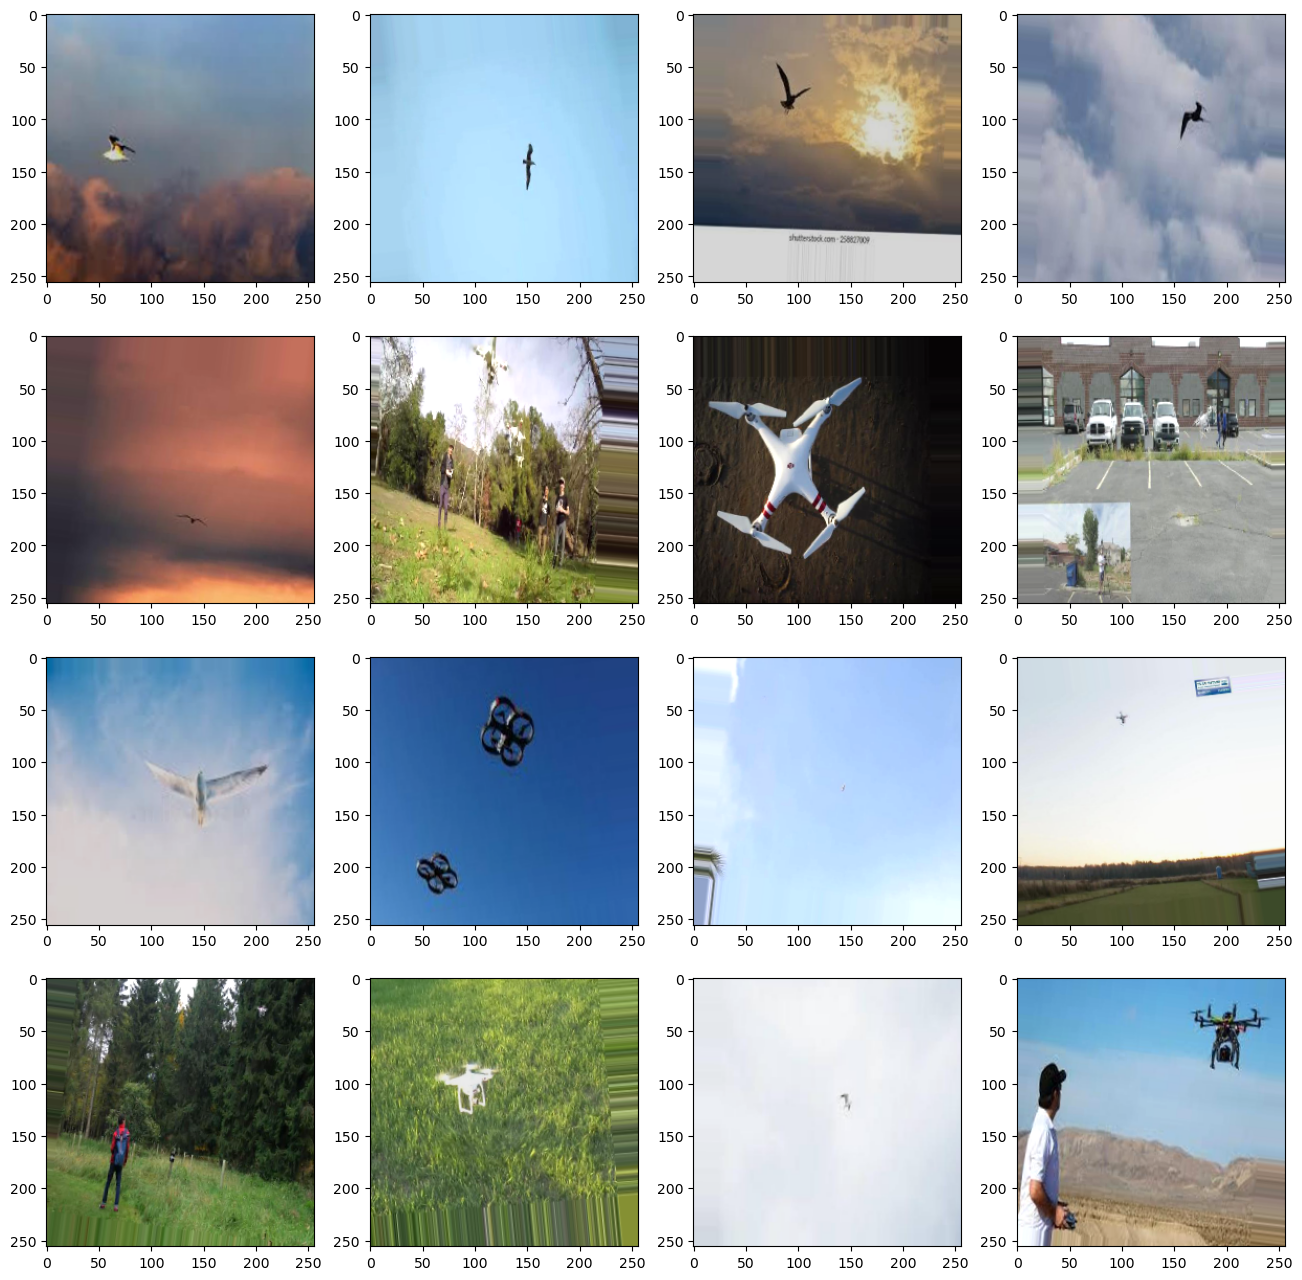

In [11]:
# Affichage de données d'exemple prises au hasard dans le dataframe mélangé

w = 10
h = 10

x= train_gen.next()
image = x[0]
fig = plt.figure(figsize=(16, 16))
columns = 4
rows = 4
for i in range(1, columns*rows +1):
    img = image[i]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
plt.show()

In [12]:
# Utilisation d'un générateur de données d'image avec les niveaux de gris
generator_grey = ImageDataGenerator(
        rescale = 1/255,
        validation_split=0.3,
        rotation_range=8, # rotation
        width_shift_range=0.1, # horizontal shift
        height_shift_range=0.1, # vertical shift
        zoom_range=0.2, # zoom
        horizontal_flip=True, # horizontal flip
        brightness_range=[0.8,1.3] # brightness
    
)

In [13]:
# Séparation des données d'apprentissage et de test
train_gen_grey = generator_grey.flow_from_dataframe(df1,x_col='path',y_col='label',target_size=(256,256),
                                          batch_size=32,
                                        color_mode='grayscale',
                                          class_mode='categorical',subset='training',seed=42)
val_gen_grey = generator_grey.flow_from_dataframe(df1,x_col='path',y_col='label',target_size=(256,256),
                                        batch_size=32,
                                      color_mode='grayscale',
                                        class_mode='categorical',subset='validation',seed=42)

Found 586 validated image filenames belonging to 2 classes.
Found 250 validated image filenames belonging to 2 classes.


In [14]:
import tensorflow as tf
# Création du modèle d'apprentissage
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(256, 256, 1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2,activation='softmax')
])

In [15]:
# Compilation du modèle en utilisant la loss de categorical crossentropy
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [16]:
import time
# Entrainement du modèle
ts=time.time()
history=model.fit(
        train_gen_grey,
        epochs=20,
        validation_data=val_gen_grey)
te=time.time()
t_train_conv = te-ts

Epoch 1/20
19/19 [==============================] - 6s 299ms/step - loss: 0.7932 - accuracy: 0.6143 - val_loss: 4.7447 - val_accuracy: 0.4600
Epoch 2/20
19/19 [==============================] - 6s 299ms/step - loss: 0.6899 - accuracy: 0.6416 - val_loss: 3.1711 - val_accuracy: 0.4600
Epoch 3/20
19/19 [==============================] - 5s 280ms/step - loss: 0.6394 - accuracy: 0.6570 - val_loss: 2.3699 - val_accuracy: 0.4720
Epoch 4/20
19/19 [==============================] - 5s 280ms/step - loss: 0.6163 - accuracy: 0.6604 - val_loss: 1.2256 - val_accuracy: 0.5040
Epoch 5/20
19/19 [==============================] - 6s 298ms/step - loss: 0.5877 - accuracy: 0.6724 - val_loss: 1.2140 - val_accuracy: 0.4920
Epoch 6/20
19/19 [==============================] - 5s 285ms/step - loss: 0.5828 - accuracy: 0.6809 - val_loss: 1.1972 - val_accuracy: 0.5120
Epoch 7/20
19/19 [==============================] - 6s 322ms/step - loss: 0.5674 - accuracy: 0.7082 - val_loss: 1.1614 - val_accuracy: 0.5560
Epoch 

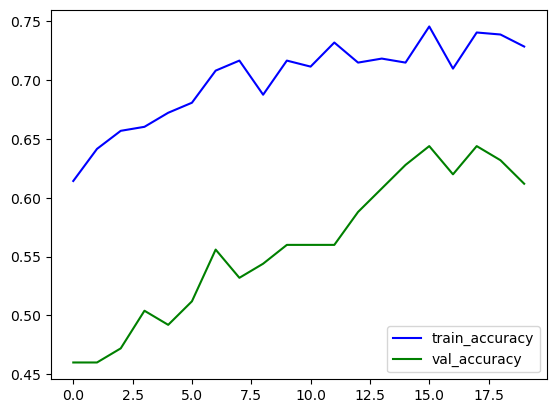

In [17]:
# Graphique représentant l'accuracy apprentissage et l'accuracy test 
hist=history.history
plt.plot(hist["accuracy"],color="b",label="train_accuracy")
plt.plot(hist["val_accuracy"],color="g",label="val_accuracy")
plt.legend(loc="lower right")
plt.show()

In [18]:
model.evaluate(train_gen_grey)

19/19 [==============================] - 3s 170ms/step - loss: 0.7613 - accuracy: 0.6672


[0.7613300085067749, 0.6672354936599731]

In [19]:
eval = model.evaluate(val_gen_grey)

8/8 [==============================] - 1s 170ms/step - loss: 0.8196 - accuracy: 0.6040


In [20]:
files=val_gen_grey.filenames
class_dict=val_gen_grey.class_indices # dictionnaire contenant les deux classes (bird et drone)
rev_dict={}
for key, value in class_dict.items():
    rev_dict[value]=key

In [21]:
# Prédiction du modèle après apprentissage avec les valeurs de test échelle de gris
predictions = model.predict(val_gen_grey)

8/8 [==============================] - 2s 190ms/step


In [22]:
from keras.preprocessing import image
# Fonction de classification pour l'affichage de la prédiction
def classify(value):
    if value == 0:
        return 'bird'
    else:
        return 'drone'

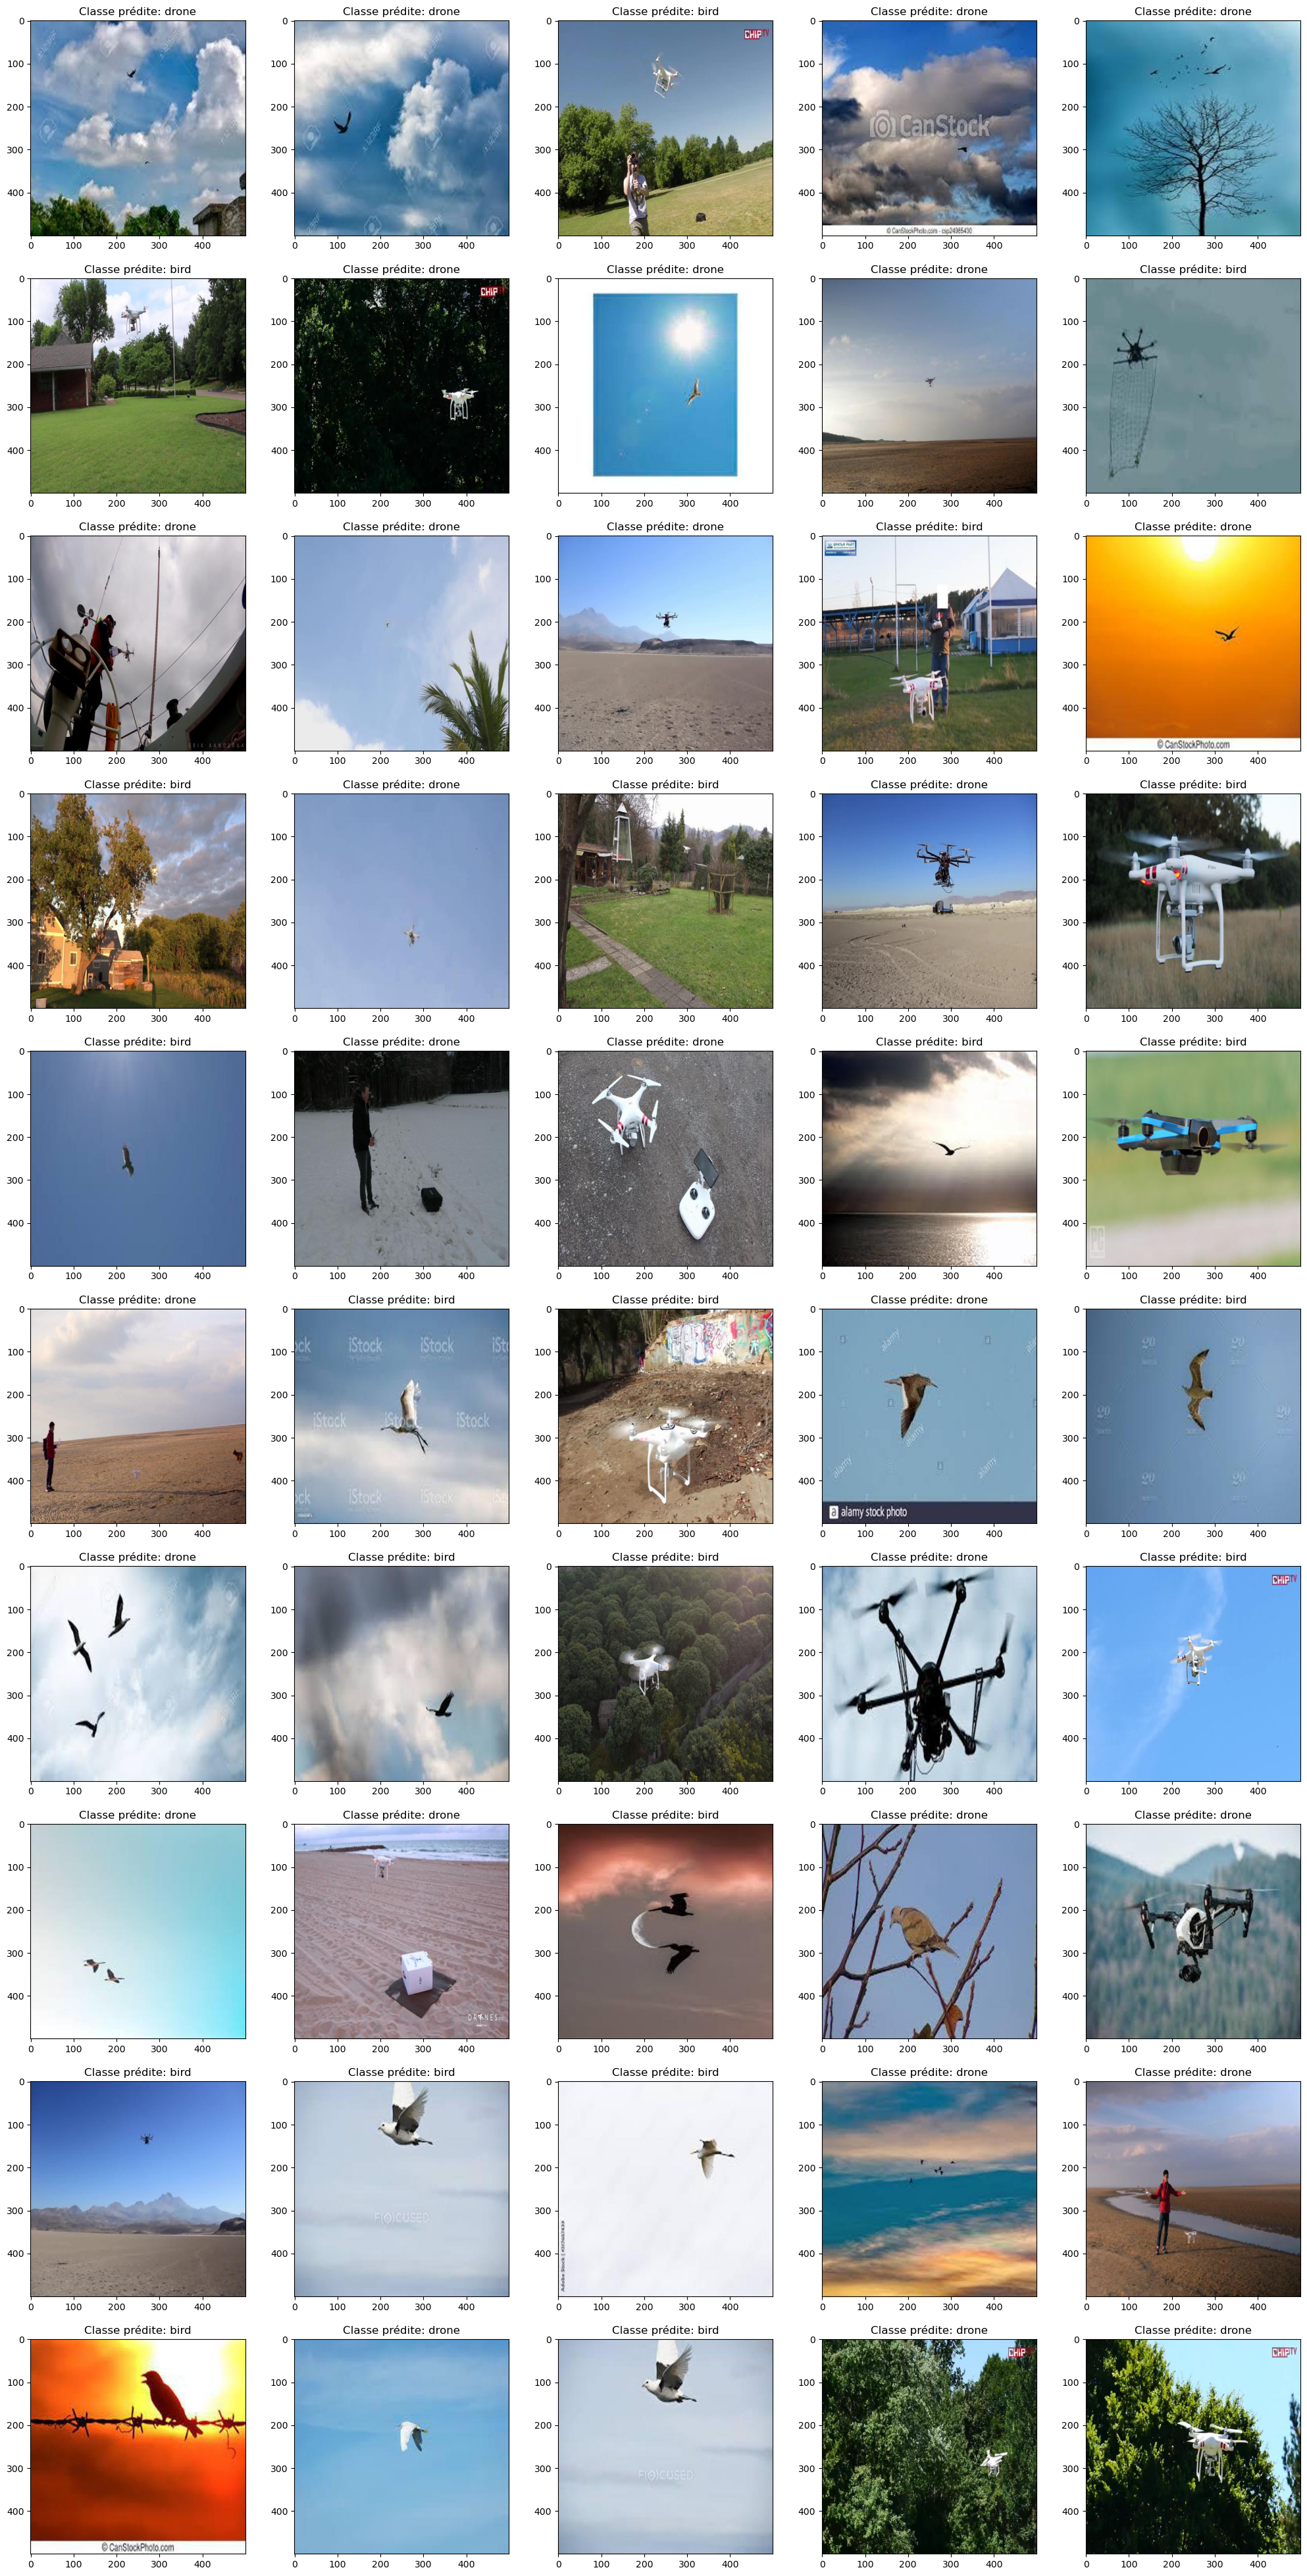

In [23]:
# Affichage des prédictions obtenues avec les images concernées
fig = plt.figure(figsize=(25, 50))
columns = 5
rows = 10
predicted_values = []
for i in range(250):
    index=np.argmax(predictions[i])
    predicted_values.append(index)
for i in range(1, columns*rows +1):
    index=np.argmax(predictions[i])
    klass=rev_dict[index] 
    im = Image.open(files[i])
    img=np.array(im)
    fig.add_subplot(rows, columns, i)
    plt.imshow(img)
    plt.title(f'Classe prédite: { klass}')
plt.show()


Test loss: 0.8195524215698242
Test accuracy: 0.6039999723434448
Time Running: 112.22 seconds


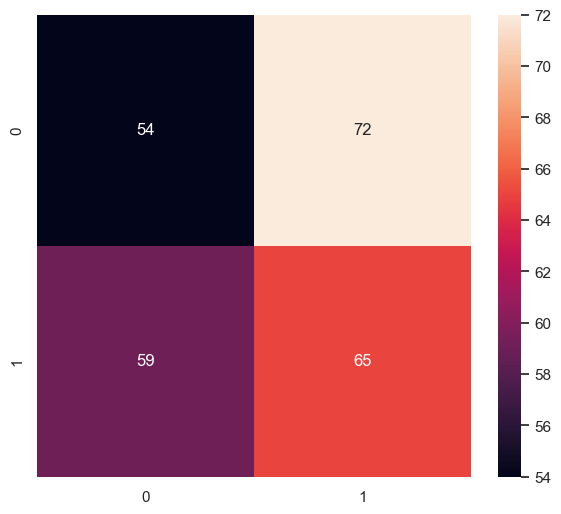

In [24]:
# Matrice de confusion avec loss, accuracy et temps total écoulé
import seaborn as sb
sb.set()
from sklearn.metrics import confusion_matrix


print('Test loss:', eval[0])
print('Test accuracy:', eval[1])
print("Time Running: %.2f seconds" %t_train_conv )
fig=plt.figure(figsize=(7,6))
ax = fig.add_subplot(1,1,1)

ax = sb.heatmap(pd.DataFrame(confusion_matrix(predicted_values, val_gen_grey.classes)), annot=True, fmt="d")
# Conclusion : modèle inefficace et trop imprécis. 
# Peut être dû à un trop petit volume de données d'entrainement, données de test trop différentes ?